In [252]:
import os
import sys
import time
from random import shuffle

import numpy as np
from scipy.spatial.distance import pdist, squareform

from sklearn.utils.class_weight import compute_class_weight

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.collections import LineCollection

from tqdm import tqdm, trange
from functools import partial
from torch.utils.tensorboard import SummaryWriter

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Primary device: {device}")

Primary device: cuda:0


In [253]:
class DotDict(dict):
    """Dictionary wrapper to access keys as attributes."""
    def __getattr__(self, key):
        return self.get(key)

def build_global_vocabulary(num_nodes=50):
    """
    Build a canonical ordering of edges (i < j) for up to num_nodes=50.
    Also add special tokens: <PAD>, <START>, <END>
    Returns:
        edge_to_token: dict (i,j) -> token_id
        token_to_edge: dict token_id -> (i,j)
    """
    edges = []
    for i in range(num_nodes):
        for j in range(i+1, num_nodes):
            edges.append((i, j))
    # Sort them lexicographically => canonical ordering
    edges.sort(key=lambda x: (x[0], x[1]))
    edge_to_token = {}
    token_to_edge = {}
    for idx, (i, j) in enumerate(edges):
        edge_to_token[(i, j)] = idx
        token_to_edge[idx] = (i, j)
    
    # Special Tokens
    PAD_TOKEN = len(edges)
    START_TOKEN = len(edges) + 1
    END_TOKEN = len(edges) + 2
    
    edge_to_token['<PAD>'] = PAD_TOKEN
    edge_to_token['<START>'] = START_TOKEN
    edge_to_token['<END>'] = END_TOKEN
    
    token_to_edge[PAD_TOKEN] = '<PAD>'
    token_to_edge[START_TOKEN] = '<START>'
    token_to_edge[END_TOKEN] = '<END>'
    
    return edge_to_token, token_to_edge

In [254]:
class TSPDataset(Dataset):
    """
    Expects lines: x1 y1 x2 y2 ... xN yN output 1 2 3 ... N 1
    Produces:
      - coords: node coordinates (N, 2)
      - x_edges, x_edges_values: adjacency + distance
      - topDownTokens, leftRightTokens, token_seq: edge token sequences
      - edge_rank: optional ranking
      - x_mid, y_mid
    """

    def __init__(self, filepath, num_nodes=50, edge_to_token=None, token_to_edge=None,
                 num_neighbors=-1, device='cpu', voc_size=None):
        super().__init__()
        self.num_nodes = num_nodes
        self.edge_to_token = edge_to_token  # global edge->token mapping
        self.token_to_edge = token_to_edge  # reverse mapping
        self.num_neighbors = num_neighbors
        self.device = device

        if voc_size is None:
            voc_size = len(edge_to_token)
        self.voc_size = voc_size

        with open(filepath, "r") as f:
            lines = f.readlines()
        self.lines = lines

    def __len__(self):
        return len(self.lines)

    def __getitem__(self, idx):
        line = self.lines[idx].strip().split()
        if len(line) < 2*self.num_nodes:
            raise ValueError(f"Line {idx} too short to have {2*self.num_nodes} coords.")

        coords = np.array(line[:2*self.num_nodes], dtype=np.float32).reshape(self.num_nodes, 2)
        coords_swapped = coords[:, [1, 0]]
        
        # solution parse
        try:
            output_idx = line.index('output')
        except ValueError:
            raise ValueError("No 'output' in line.")
        sol_nodes = [int(x)-1 for x in line[output_idx+1:] if x.isdigit()]
        if len(sol_nodes) != self.num_nodes+1 or sol_nodes[0] != sol_nodes[-1]:
            raise ValueError("Solution tour not matching expected length or not cyclic.")
        sol_nodes = sol_nodes[:-1]  # remove the repeat

        x_mid = coords[:, 0].mean()
        y_mid = coords[:, 1].mean()

        # define quadrant
        quadrants = np.ones(self.num_nodes, dtype=int)
        quadrants[coords[:, 0] < x_mid] = 2
        quadrants[coords[:, 1] < y_mid] = 4
        quadrants[(coords[:, 0] < x_mid) & (coords[:, 1] < y_mid)] = 3

        # collect top-down edges
        topDownEdgePairs = []
        for i in range(self.num_nodes):
            j = (i + 1) % self.num_nodes
            q_i = quadrants[sol_nodes[i]]
            q_j = quadrants[sol_nodes[j]]
            if ((q_i in [1, 2] and q_j in [3, 4]) or (q_j in [1, 2] and q_i in [3, 4])):
                topDownEdgePairs.append((min(sol_nodes[i], sol_nodes[j]),
                                         max(sol_nodes[i], sol_nodes[j])))

        # collect left-right edges
        leftRightEdgePairs = []
        for i in range(self.num_nodes):
            j = (i + 1) % self.num_nodes
            q_i = quadrants[sol_nodes[i]]
            q_j = quadrants[sol_nodes[j]]
            if ((q_i in [1, 4] and q_j in [2, 3]) or (q_j in [1, 4] and q_i in [2, 3])):
                leftRightEdgePairs.append((min(sol_nodes[i], sol_nodes[j]),
                                           max(sol_nodes[i], sol_nodes[j])))

        def sort_and_tokenize(edgePairs):
            edgePairs = list(set(edgePairs))
            edgePairs.sort(key=lambda x: (x[0], x[1]))
            tokens = [self.edge_to_token[(i, j)] for (i, j) in edgePairs]
            return tokens

        START_TOKEN = self.edge_to_token['<START>']
        END_TOKEN = self.edge_to_token['<END>']

        topDownTokens = [START_TOKEN] + sort_and_tokenize(topDownEdgePairs) + [END_TOKEN]
        leftRightTokens = [START_TOKEN] + sort_and_tokenize(leftRightEdgePairs) + [END_TOKEN]
        final_token_seq = [START_TOKEN] + topDownTokens + leftRightTokens + [END_TOKEN]

        W_val = squareform(pdist(coords, metric='euclidean'))  # (N, N)
        if self.num_neighbors == -1:
            W = np.ones((self.num_nodes, self.num_nodes), dtype=np.float32)
        else:
            W = np.zeros((self.num_nodes, self.num_nodes), dtype=np.float32)
            knns = np.argpartition(W_val, self.num_neighbors, axis=1)[:, :self.num_neighbors]
            W[np.arange(self.num_nodes)[:, None], knns] = 1
        np.fill_diagonal(W, 2)

        #Generate a matrix of shape V, V. (i, j) is 1 if node i and node j are a topdown edge
        y_edges_topdown = np.zeros((self.num_nodes, self.num_nodes))
        for i, j in topDownEdgePairs:
            y_edges_topdown[i, j] = 1
            y_edges_topdown[j, i] = 1

        # Rank edges according to closeness to vertical axis (not used currently)
        edge_rank = np.full((self.voc_size,), -999999, dtype=np.float32)
        for token_id in range(self.voc_size - 3):
            if token_id not in self.token_to_edge:
                continue
            i, j = self.token_to_edge[token_id]
            if i < self.num_nodes and j < self.num_nodes:
                if (W[i, j] == 1) or (W[j, i] == 1):
                    meanX = (coords[i, 0] + coords[j, 0]) / 2.0
                    diff = abs(meanX - x_mid)
                    edge_rank[token_id] = -diff

        sample = {
            'coords': torch.tensor(coords, dtype=torch.float, device=self.device),
            'coords_swapped': torch.tensor(coords_swapped, dtype=torch.float, device=self.device),
            'x_edges': torch.tensor(W, dtype=torch.long, device=self.device),
            'x_edges_values': torch.tensor(W_val, dtype=torch.float, device=self.device),
            'topDownTokens': torch.tensor(topDownTokens, dtype=torch.long, device=self.device),
            'leftRightTokens': torch.tensor(leftRightTokens, dtype=torch.long, device=self.device),
            'token_seq': torch.tensor(final_token_seq, dtype=torch.long, device=self.device),
            'edge_rank': torch.tensor(edge_rank, dtype=torch.float, device=self.device),
            'x_mid': torch.tensor(x_mid, dtype=torch.float, device=self.device),
            'y_mid': torch.tensor(y_mid, dtype=torch.float, device=self.device),
            'y_edges_topdown': torch.tensor(y_edges_topdown, dtype=torch.long, device=self.device)
        }
        return sample

In [255]:
def collate_fn(batch, edge_to_token):
    coords = torch.stack([sample['coords'] for sample in batch], dim=0)  
    coords_swapped = torch.stack([sample['coords_swapped'] for sample in batch], dim=0)  
    x_edges = torch.stack([sample['x_edges'] for sample in batch], dim=0)  
    x_edges_values = torch.stack([sample['x_edges_values'] for sample in batch], dim=0)
    edge_rank = torch.stack([sample['edge_rank'] for sample in batch], dim=0)  
    x_mid = torch.stack([sample['x_mid'] for sample in batch], dim=0)  
    y_mid = torch.stack([sample['y_mid'] for sample in batch], dim=0)  

    PAD_TOKEN = edge_to_token['<PAD>']

    token_seqs = [sample['token_seq'] for sample in batch]
    token_seqs_padded = pad_sequence(token_seqs, batch_first=True, padding_value=PAD_TOKEN)

    td_token_seqs = [sample['topDownTokens'] for sample in batch]
    td_token_seqs_padded = pad_sequence(td_token_seqs, batch_first=True, padding_value=PAD_TOKEN)

    lr_token_seqs = [sample['leftRightTokens'] for sample in batch]
    lr_token_seqs_padded = pad_sequence(lr_token_seqs, batch_first=True, padding_value=PAD_TOKEN)

    y_edges_topdown = torch.stack([sample['y_edges_topdown'] for sample in batch], dim=0)

    return {
        'coords': coords,
        'coords_swapped': coords_swapped,
        'x_edges': x_edges,
        'x_edges_values': x_edges_values,
        'token_seq': token_seqs_padded,
        'topDownTokens': td_token_seqs_padded,
        'leftRightTokens': lr_token_seqs_padded,
        'edge_rank': edge_rank,
        'x_mid': x_mid,
        'y_mid': y_mid,
        'y_edges_topdown': y_edges_topdown
    }

In [256]:
temp_edge2tok, temp_tok2edge = build_global_vocabulary(50)
dataset_dummy = TSPDataset(filepath="tsp-data/tsp50_test_concorde.txt", num_nodes=50, edge_to_token=temp_edge2tok, token_to_edge=temp_tok2edge)
collate_fn = partial(collate_fn, edge_to_token=temp_edge2tok)
dataloader_dummy = DataLoader(dataset_dummy, batch_size=32, shuffle=True, collate_fn=collate_fn)
data_dict = next(iter(dataloader_dummy))
data_dict['coords'].size(), data_dict['x_edges'].size(), data_dict['x_edges_values'].size(), data_dict['topDownTokens'].size(), data_dict['leftRightTokens'].size(), data_dict['edge_rank'].size(), data_dict['y_edges_topdown'].size()

(torch.Size([32, 50, 2]),
 torch.Size([32, 50, 50]),
 torch.Size([32, 50, 50]),
 torch.Size([32, 8]),
 torch.Size([32, 8]),
 torch.Size([32, 1228]),
 torch.Size([32, 50, 50]))

In [257]:
def visualize_sample(batch, edge_to_token, token_to_edge, N=2):
    """
    Visualize a single sample from the batch.

    Args:
        batch (dict): A batch from DataLoader.
        edge_to_token (dict): Mapping from edge tuples to token IDs.
        token_to_edge (dict): Mapping from token IDs to edge tuples.
        edge_rank (torch.Tensor): Tensor of shape (B, vocab_size) with edge ranks.
        N (int): Number of top edges to highlight.
    """
    # Select the first sample in the batch
    sample = {k: v[0] for k, v in batch.items()}
    
    coords = sample['coords'].cpu().numpy()                # (N, 2)
    x_edges = sample['x_edges'].cpu().numpy()              # (N, N)
    topDownTokens = sample['topDownTokens'].cpu().numpy()  # List of tokens
    leftRightTokens = sample['leftRightTokens'].cpu().numpy()  # List of tokens
    edge_rank_sample = sample['edge_rank'].cpu().numpy()   # (vocab_size,)
    x_mid = sample['x_mid'].cpu().numpy()
    y_mid = sample['y_mid'].cpu().numpy()
    
    plt.figure(figsize=(8, 8))
    
    # Plot all nodes
    plt.scatter(coords[:, 0], coords[:, 1], color='blue', label='Nodes')
    
    '''
    # Plot all valid x_edges as thin grey lines
    for i in range(len(coords)):
        for j in range(i + 1, len(coords)):
            if x_edges[i, j] == 1:
                plt.plot([coords[i, 0], coords[j, 0]],
                         [coords[i, 1], coords[j, 1]],
                         color='grey', linewidth=0.5)
    '''
    
    # Plot top-down edges (excluding special tokens)
    topDownTokens_trimmed = [t for t in topDownTokens if t not in [edge_to_token['<PAD>'], edge_to_token['<START>'], edge_to_token['<END>']]]
    for token in topDownTokens_trimmed:
        if token in token_to_edge:
            i, j = token_to_edge[token]
            plt.plot([coords[i, 0], coords[j, 0]],
                     [coords[i, 1], coords[j, 1]],
                     color='red', linewidth=2, label='Top-Down Edge' if token == topDownTokens_trimmed[0] else "")
    
    # Plot left-right edges (excluding special tokens)
    leftRightTokens_trimmed = [t for t in leftRightTokens if t not in [edge_to_token['<PAD>'], edge_to_token['<START>'], edge_to_token['<END>']]]
    for token in leftRightTokens_trimmed:
        if token in token_to_edge:
            i, j = token_to_edge[token]
            plt.plot([coords[i, 0], coords[j, 0]],
                     [coords[i, 1], coords[j, 1]],
                     color='green', linewidth=2, label='Left-Right Edge' if token == leftRightTokens_trimmed[0] else "")
    
    # Highlight top N edges based on edge_rank
    if len(topDownTokens_trimmed) > 0:
        # Get ranks for valid topDownTokens
        valid_tokens = torch.tensor(topDownTokens_trimmed, dtype=torch.long)
        ranks = edge_rank_sample[topDownTokens_trimmed]
        # Get top N tokens with highest rank (least negative)
        topN_indices = torch.topk(torch.tensor(ranks), N, largest=True).indices
        topN_tokens = valid_tokens[topN_indices].cpu().numpy()
        for token in topN_tokens:
            if token in token_to_edge:
                i, j = token_to_edge[token]
                plt.plot([coords[i, 0], coords[j, 0]],
                         [coords[i, 1], coords[j, 1]],
                         color='orange', linewidth=3, label='Top-N Edge' if token == topN_tokens[0] else "")
    
    # Plot x_mid and y_mid
    plt.axvline(x=x_mid, color='purple', linestyle='--', label='x_mid')
    plt.axhline(y=y_mid, color='brown', linestyle='--', label='y_mid')
    
    plt.legend()
    plt.title("TSP Sample Visualization")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.show()

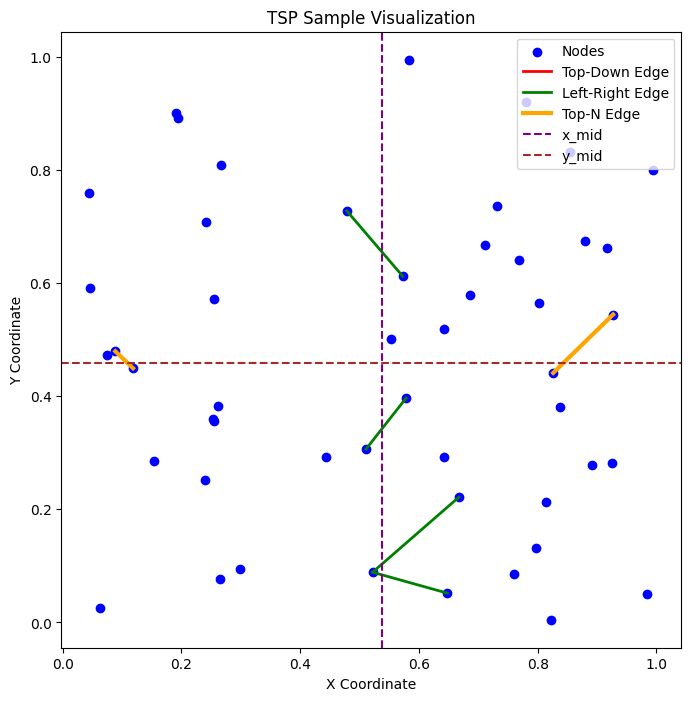

In [258]:
edge2tok, tok2edge = build_global_vocabulary(50) 
dummy_dataset = TSPDataset("tsp-data/tsp50_micro.txt", num_nodes=50, edge_to_token=edge2tok, token_to_edge=tok2edge, device=device)
collate_fn = partial(collate_fn, edge_to_token=edge2tok)
dummy_loader = DataLoader(dummy_dataset, batch_size=1, shuffle=True, drop_last=False, collate_fn=collate_fn)

sample = next(iter(dummy_loader))
visualize_sample(sample, edge2tok, tok2edge, N=2)

In [259]:
class BatchNormNode(nn.Module):
    """Batch normalization for node features."""
    def __init__(self, hidden_dim):
        super(BatchNormNode, self).__init__()
        self.batch_norm = nn.BatchNorm1d(hidden_dim, track_running_stats=False)
    def forward(self, x):
        # x: (B, V, H)
        x = x.transpose(1, 2).contiguous()  # (B, H, V)
        x = self.batch_norm(x)
        x = x.transpose(1, 2).contiguous()  # (B, V, H)
        return x

class BatchNormEdge(nn.Module):
    """Batch normalization for edge features."""
    def __init__(self, hidden_dim):
        super(BatchNormEdge, self).__init__()
        self.batch_norm = nn.BatchNorm2d(hidden_dim, track_running_stats=False)
    def forward(self, e):
        # e: (B, V, V, H)
        e = e.permute(0, 3, 1, 2).contiguous()  # (B, H, V, V)
        e = self.batch_norm(e)
        e = e.permute(0, 2, 3, 1).contiguous()  # (B, V, V, H)
        return e

class NodeFeatures(nn.Module):
    def __init__(self, hidden_dim, aggregation="mean"):
        super(NodeFeatures, self).__init__()
        self.aggregation = aggregation
        self.U = nn.Linear(hidden_dim, hidden_dim)
        self.V = nn.Linear(hidden_dim, hidden_dim)
    def forward(self, x, edge_gate):
        # x: (B, V, H)
        # edge_gate: (B, V, V, H)
        Ux = self.U(x)              # (B, V, H)
        Vx = self.V(x).unsqueeze(1) # (B, 1, V, H)
        gateVx = edge_gate * Vx     # (B, V, V, H)
        if self.aggregation == "mean":
            aggregation = gateVx.sum(dim=2) / (edge_gate.sum(dim=2) + 1e-20)
        else:
            aggregation = gateVx.sum(dim=2)
        return Ux + aggregation

class EdgeFeatures(nn.Module):
    def __init__(self, hidden_dim):
        super(EdgeFeatures, self).__init__()
        self.U = nn.Linear(hidden_dim, hidden_dim)
        self.V = nn.Linear(hidden_dim, hidden_dim)
    def forward(self, x, e):
        # x: (B, V, H)
        # e: (B, V, V, H)
        Ue = self.U(e)          # (B, V, V, H)
        Vx_i = self.V(x).unsqueeze(2)  # (B, V, 1, H)
        Vx_j = self.V(x).unsqueeze(1)  # (B, 1, V, H)
        return Ue + Vx_i + Vx_j # (B, V, V, H)

class MLP(nn.Module):
    """Multi-layer Perceptron for output prediction."""

    def __init__(self, hidden_dim, output_dim, L=2):
        super(MLP, self).__init__()
        layers = [nn.Linear(hidden_dim, hidden_dim) for _ in range(L - 1)]
        self.U = nn.ModuleList(layers)
        self.V = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        for layer in self.U:
            x = F.relu(layer(x))
        return self.V(x)


class ResidualGatedGCNLayer(nn.Module):
    def __init__(self, hidden_dim, aggregation="sum"):
        super(ResidualGatedGCNLayer, self).__init__()
        self.node_feat = NodeFeatures(hidden_dim, aggregation)
        self.edge_feat = EdgeFeatures(hidden_dim)
        self.bn_node = BatchNormNode(hidden_dim)
        self.bn_edge = BatchNormEdge(hidden_dim)

    def forward(self, x, e):
        # x: (B, V, H)
        # e: (B, V, V, H)
        e_new = self.edge_feat(x, e) 
        edge_gate = torch.sigmoid(e_new) 
        x_new = self.node_feat(x, edge_gate)
        e_new = self.bn_edge(e_new)
        x_new = self.bn_node(x_new)
        e_new = F.relu(e_new)
        x_new = F.relu(x_new)
        return x + x_new, e + e_new

In [260]:
class ResidualGatedGCNModelPretrain(nn.Module):
    """Residual Gated GCN Model for learning good node embeddings + edge embeddings."""
    def __init__(self, config):
        super().__init__()
        self.num_nodes = config.num_nodes
        self.hidden_dim = config.hidden_dim
        self.num_layers = config.num_layers
        self.aggregation = config.aggregation

        self.nodes_coord_embedding = nn.Linear(config.node_dim, self.hidden_dim, bias=False)
        self.edges_values_embedding = nn.Linear(1, self.hidden_dim // 2, bias=False)
        self.edges_embedding = nn.Embedding(config.voc_edges_in, self.hidden_dim // 2)

        self.gcn_layers = nn.ModuleList([
            ResidualGatedGCNLayer(self.hidden_dim, self.aggregation) 
            for _ in range(self.num_layers)
        ])

        self.mlp_edges = MLP(self.hidden_dim, config.voc_edges_out, config.mlp_layers)

    def loss_edges(self, y_pred_edges, y_edges, edge_cw):
        """Compute loss for edge predictions."""
        y = F.log_softmax(y_pred_edges, dim=3)  # (B, V, V, O)
        y = y.permute(0, 3, 1, 2).contiguous()  # (B, O, V, V)
        return nn.NLLLoss(weight=edge_cw)(y, y_edges)

    def forward(self, x_edges, x_edges_values, x_nodes_coord):
        """
        Returns:
            x: (B, V, H) node embeddings
            e: (B, V, V, H) edge embeddings
        """
        x = self.nodes_coord_embedding(x_nodes_coord)                        # (B, V, H)
        e_vals = self.edges_values_embedding(x_edges_values.unsqueeze(-1))   # (B, V, V, H//2)
        e_tags = self.edges_embedding(x_edges)                               # (B, V, V, H//2)
        e = torch.cat((e_vals, e_tags), dim=-1)                              # (B, V, V, H)

        for layer in self.gcn_layers:
            x, e = layer(x, e)
            
        y_pred_edges = self.mlp_edges(e)  # (B, V, V, O)
        return y_pred_edges
    
class ResidualGatedGCNModelTransformer(nn.Module):
    """Residual Gated GCN Model for node embeddings + edge embeddings."""
    def __init__(self, config):
        super().__init__()
        self.num_nodes = config.num_nodes
        self.hidden_dim = config.hidden_dim
        self.num_layers = config.num_layers
        self.aggregation = config.aggregation

        self.nodes_coord_embedding = nn.Linear(config.node_dim, self.hidden_dim, bias=False)
        self.edges_values_embedding = nn.Linear(1, self.hidden_dim // 2, bias=False)
        self.edges_embedding = nn.Embedding(config.voc_edges_in, self.hidden_dim // 2)

        self.gcn_layers = nn.ModuleList([
            ResidualGatedGCNLayer(self.hidden_dim, self.aggregation) 
            for _ in range(self.num_layers)
        ])

    def forward(self, x_edges, x_edges_values, x_nodes_coord):
        """
        Returns:
            x: (B, V, H) node embeddings
            e: (B, V, V, H) edge embeddings
        """
        x = self.nodes_coord_embedding(x_nodes_coord)                        # (B, V, H)
        e_vals = self.edges_values_embedding(x_edges_values.unsqueeze(-1))   # (B, V, V, H//2)
        e_tags = self.edges_embedding(x_edges)                               # (B, V, V, H//2)
        e = torch.cat((e_vals, e_tags), dim=-1)                              # (B, V, V, H)

        for layer in self.gcn_layers:
            x, e = layer(x, e)
        return x, e

In [261]:
########################################################################
# Key Change: We do NOT embed tokens with an Embedding table. Instead,
# for token t = (i,j), we fetch the GCN edge embedding e[b,i,j,:].
# We keep a small embedding table only for special tokens: <PAD>, <START>, <END>.
# So the decoder input is shape (B, L, H).
########################################################################

class GCNEdgeEmbeddingLookup(nn.Module):
    """
    Replaces standard token embedding.  
    For each token t:
      - If t is <PAD>, <START>, <END>, look up from a special embedding table
      - Else, find (i,j) from token->edge, and fetch from gcn_edge_emb[b,i,j,:].
    We assume we have e of shape (B, V, V, H). The decoder will call embed_tokens
    each step with the current 'generated tokens'.
    """

    def __init__(self, token_to_edge, d_model, pad_idx, start_idx, end_idx):
        super().__init__()
        self.token_to_edge = token_to_edge
        self.d_model = d_model
        self.pad_idx = pad_idx
        self.start_idx = start_idx
        self.end_idx = end_idx
        # We'll keep embeddings for these special tokens only
        self.special_token_emb = nn.Embedding(3, d_model)
        # We'll map pad->0, start->1, end->2 internally
        self.special_token_map = {
            pad_idx: 0,
            start_idx: 1,
            end_idx: 2
        }

    def forward(self, tokens, edge_emb):
        """
        Args:
            tokens: shape (B, L)
            edge_emb: shape (B, V, V, H)
        Returns:
            out_emb: shape (B, L, H)
        """
        B, L = tokens.shape
        device = tokens.device
        H = edge_emb.size(-1)

        # We'll build an output tensor of shape (B, L, H)
        out = torch.zeros((B, L, H), device=device)

        # Step 1: Identify special tokens
        # We'll make a mask for each of the 3 special tokens, then fill in from special_token_emb
        # for the rest, we do the gcn lookup
        # special_mask[b, l] = which special token index or -1 if not special
        special_mask = torch.full((B, L), -1, dtype=torch.long, device=device)
        for st_idx, sp_idx in self.special_token_map.items():
            # st_idx is the global token ID, sp_idx is 0..2
            st_mask = (tokens == st_idx)
            special_mask[st_mask] = sp_idx
        
        # Fill special tokens
        # Gather indices to feed into special_token_emb
        special_positions = (special_mask >= 0).nonzero(as_tuple=False)  # shape (M, 2) => (batch_idx, seq_idx)
        if special_positions.size(0) > 0:
            # shape (M,)
            special_indices = special_mask[special_positions[:,0], special_positions[:,1]]
            # shape (M, d_model)
            special_vectors = self.special_token_emb(special_indices)
            out[special_positions[:,0], special_positions[:,1], :] = special_vectors

        # Step 2: For non-special tokens, do GCN lookup
        # non_special_mask => (tokens != pad_idx) & (tokens != start_idx) & (tokens != end_idx)
        non_special_mask = (special_mask < 0)
        non_special_positions = non_special_mask.nonzero(as_tuple=False) # shape (K, 2)
        if non_special_positions.size(0) > 0:
            # tokens for those positions
            non_special_tokens = tokens[non_special_positions[:,0], non_special_positions[:,1]]
            # For each token ID, find (i,j)
            # We'll create i_j array of shape (K,2)
            i_j = []
            for t_id in non_special_tokens.cpu().tolist():
                i_j.append(self.token_to_edge[t_id])  # (i,j)
            i_j = torch.tensor(i_j, dtype=torch.long, device=device)  # (K,2)
            i_idx = i_j[:,0]  # (K,)
            j_idx = i_j[:,1]  # (K,)

            # Now gather from edge_emb => shape (B, V, V, H)
            # We have batch indices and seq positions in non_special_positions
            b_idx = non_special_positions[:, 0]  # (K,)

            # edge_emb[b_idx, i_idx, j_idx, :] => (K, H)
            gcn_vectors = edge_emb[b_idx, i_idx, j_idx, :]
            out[b_idx, non_special_positions[:,1], :] = gcn_vectors

        return out

In [262]:
class TransformerGCNEdgeDecoder(nn.Module):
    """
    Autoregressive Transformer decoder that:
      - For each token in tgt_tokens, we fetch its embedding from GCN edges or special_token_emb
      - We then feed this sequence into a standard TransformerDecoder
      - Output => vocab_size
    No positional encoding for simplicity.
    """
    def __init__(self, d_model=256, vocab_size=1228, nhead=4, num_layers=4,
                 pad_idx=1225, start_idx=1226, end_idx=1227,
                 token_to_edge=None):
        super().__init__()
        self.d_model = d_model
        self.vocab_size = vocab_size
        self.pad_idx = pad_idx
        self.start_idx = start_idx
        self.end_idx = end_idx

        self.embedding_lookup = GCNEdgeEmbeddingLookup(
            token_to_edge=token_to_edge,
            d_model=d_model,
            pad_idx=pad_idx,
            start_idx=start_idx,
            end_idx=end_idx
        )
        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead,
                                                   dim_feedforward=d_model*4,
                                                   activation='relu',
                                                   batch_first=True)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.output_projection = nn.Linear(d_model, vocab_size)
    
    def _generate_square_subsequent_mask(self, sz, device):
        # mask shape (sz, sz) => True means blocked
        mask = torch.triu(torch.ones(sz, sz, dtype=torch.bool, device=device), diagonal=1)
        return mask

    def forward(self, tgt_tokens, edge_emb, node_emb=None, tgt_mask=None):
        """
        Args:
          tgt_tokens: (B, L) token IDs
          edge_emb:   (B, V, V, d_model) => GCN edge embeddings
          node_emb:   (B, V, d_model) => Node embeddings if we want cross-attn
                      (Optional: we won't do cross-attn here, or if we do, we'd reshape node_emb for memory)
        Returns:
          logits => (B, L, vocab_size)
        """
        B, L = tgt_tokens.shape
        # Build embedding from edge_emb
        tgt_emb = self.embedding_lookup(tgt_tokens, edge_emb)  # (B, L, d_model)

        if tgt_mask is None:
            # (L,L) with True => block
            tgt_mask = self._generate_square_subsequent_mask(L, device=tgt_tokens.device)

        # If we want cross-attention with node_emb, we must pass memory as shape (B, S, E).
        # For simplicity, let's ignore cross-attn or only do self-attn for edges.
        # However, if you want to incorporate node_emb, you can do:
        # memory = node_emb => shape (B, V, d_model)
        # out = self.decoder(tgt=tgt_emb, memory=memory, tgt_mask=...)
        # We'll set memory=None => no cross-attn
        memory = node_emb
        out = self.decoder(tgt=tgt_emb, memory=memory, tgt_mask=tgt_mask)  # (B, L, d_model)
        logits = self.output_projection(out)                              # (B, L, vocab_size)
        return logits

In [263]:
class GCNTransformerEdgeModel(nn.Module):
    def __init__(self, config, edge_vocab_size, token_to_edge):
        super().__init__()
        self.gcn = ResidualGatedGCNModelTransformer(config)
        self.edge_vocab_size = edge_vocab_size
        self.pad_idx = config.special_tokens['PAD']
        self.start_idx = config.special_tokens['START']
        self.end_idx = config.special_tokens['END']

        self.decoder = TransformerGCNEdgeDecoder(
            d_model=config.decoder_d_model,
            vocab_size=edge_vocab_size,
            nhead=config.decoder_nhead,
            num_layers=config.decoder_layers,
            pad_idx=self.pad_idx,
            start_idx=self.start_idx,
            end_idx=self.end_idx,
            token_to_edge=token_to_edge
        )

    def forward(self, x_edges, x_edges_values, x_nodes_coord, token_seq):
        """
        1) Get node_emb, edge_emb from GCN
        2) Use edge_emb + token_seq to produce logits
        """
        #EDGE CONTEXT NOT ADDED
        node_emb, edge_emb = self.gcn(x_edges, x_edges_values, x_nodes_coord)  # (B, V, H), (B, V, V, H)
        logits = self.decoder(token_seq, edge_emb, node_emb=node_emb)          # (B, L, vocab_size)
        return logits

In [264]:
def sequence_cross_entropy(logits, target_seq, pad_token):
    """
    logits: (B,L,vocab_size)
    target_seq: (B,L)
    Returns average cross-entropy
    """
    B,L,_ = logits.shape
    # flatten
    logits_flat = logits.reshape(B*L, -1)   # (B*L, vocab_size)
    target_flat = target_seq.reshape(B*L)   # (B*L)
    loss = F.cross_entropy(logits_flat, target_flat, ignore_index=pad_token, reduction='mean')
    return loss

In [265]:
#######################################################################
#Pretrain the GCN+MLP
#######################################################################
def pretrain_one_epoch(model, dataloader, optimizer, edge_cw=None):
    model.train()
    
    running_loss = 0.0
    running_count = 0
    

    for batch_idx, batch in enumerate(dataloader):
        # Data to device
        x_edges = batch['x_edges']
        x_edges_values = batch['x_edges_values']
        x_nodes_coord = batch['coords']
        y_edges = batch['y_edges_topdown']

        # class weights
        if edge_cw is None:
            edge_labels = y_edges.view(-1).cpu().numpy()
            edge_cw_np = compute_class_weight("balanced", classes=np.unique(edge_labels), y=edge_labels)
            edge_cw = torch.tensor(edge_cw_np, dtype=torch.float, device=device)


        # Forward pass
        y_pred_edges = model(x_edges, x_edges_values, x_nodes_coord)

        # Loss
        if isinstance(model, nn.DataParallel):
            loss = model.module.loss_edges(y_pred_edges, y_edges, edge_cw)
        else:
            loss = model.loss_edges(y_pred_edges, y_edges, edge_cw)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        B = x_nodes_coord.shape[0]
        running_loss += (loss.item())*B
        running_count += B
        
    final_loss = running_loss/running_count
    return final_loss, edge_cw

In [266]:
def train_one_epoch(model, dataloader, optimizer, config, epoch):
    model.train()
    running_loss = 0.0
    running_count = 0
    pad_token = config.special_tokens['PAD']

    for batch_idx, batch in enumerate(dataloader):
        coords = batch['coords']              # (B, N, 2)
        x_edges = batch['x_edges']           # (B, N, N)
        x_edges_values = batch['x_edges_values']  # (B, N, N)
        token_seq_td = batch['topDownTokens']       # (B, L)

        

        logits_td = model(x_edges, x_edges_values, coords, token_seq_td)  # (B, L, vocab_size)

        target_seq_td = token_seq_td[:, 1:].contiguous()  # (B, L-1)

        # Adjust logits_td to exclude the last time step
        logits_td = logits_td[:, :-1, :].contiguous()    # (B, L-1, vocab_size)

        loss = sequence_cross_entropy(logits_td, target_seq_td, pad_token)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        B = coords.size(0)
        running_loss += loss.item() * B
        running_count += B

    final_loss = running_loss / running_count
    print(f"Epoch {epoch}, Train Loss: {final_loss:.4f}")
    return final_loss

In [267]:
from collections import OrderedDict

def load_pretrained_gcn(pretrain_model, final_model):
    """
    Load pretrained GCN weights into the final model's GCN module.
    
    Args:
        pretrain_model (ResidualGatedGCNModel): The pretrained GCN model with MLP.
        final_model (GCNTransformerEdgeModel): The final model with Transformer decoder.
    """
    pretrain_state_dict = pretrain_model.state_dict()
    final_state_dict = final_model.state_dict()

    # Create a new OrderedDict for the final model's GCN
    new_gcn_state_dict = OrderedDict()

    for k, v in pretrain_state_dict.items():
        # Exclude MLP layers
        if 'mlp_edges' in k:
            continue
        # Prefix 'gcn.' to match the final model's GCN module
        new_key = 'gcn.' + k
        if new_key in final_state_dict:
            new_gcn_state_dict[new_key] = v
        else:
            print(f"Warning: Key {new_key} not found in the final model's state_dict.")

    # Load the new GCN state_dict into the final model
    missing_keys, unexpected_keys = final_model.load_state_dict(new_gcn_state_dict, strict=False)

    if missing_keys:
        print(f"Missing keys in the final model's state_dict: {missing_keys}")
    if unexpected_keys:
        print(f"Unexpected keys in the final model's state_dict: {unexpected_keys}")

    print("Pretrained GCN weights loaded successfully.")

In [268]:
edge2tok, tok2edge = build_global_vocabulary(50) 
dummy_dataset = TSPDataset("tsp-data/tsp50_micro.txt", num_nodes=50, edge_to_token=edge2tok, token_to_edge=tok2edge, device=device)
collate_fn = partial(collate_fn, edge_to_token=edge2tok)
dummy_loader = DataLoader(dummy_dataset, batch_size=4, shuffle=True, drop_last=False, collate_fn=collate_fn)
dummy_val_loader = DataLoader(dummy_dataset, batch_size=1, shuffle=False, drop_last=False, collate_fn=collate_fn)

cfg_autoreg = DotDict({
    'num_nodes':50,
    'hidden_dim':8,
    'num_layers':3,
    'mlp_layers':2,
    'aggregation':'mean',
    'node_dim':2,
    'voc_edges_in':3, 
    'voc_edges_out':2,  
    'decoder_d_model':8,
    'decoder_nhead':2,
    'decoder_layers':1,
    'special_tokens': {'PAD': edge2tok['<PAD>'], 'START': edge2tok['<START>'], 'END': edge2tok['<END>']},
    'device': device
})

model_pretrain = ResidualGatedGCNModelPretrain(cfg_autoreg).to(device)
opt_pretrain = torch.optim.Adam(model_pretrain.parameters(), lr=1e-3)

edge_cw = None

for epoch in range(1, 1500):
    lss, edge_cw = pretrain_one_epoch(
        model_pretrain, 
        dummy_loader, 
        opt_pretrain, 
        edge_cw,
    )
    print(f"Epoch {epoch}, train loss={lss}")

model_ar = GCNTransformerEdgeModel(cfg_autoreg, edge_vocab_size=len(edge2tok), token_to_edge=tok2edge).to(device)
#model_auto = nn.DataParallel(model_auto)

load_pretrained_gcn(model_pretrain, model_ar)

for param in model_ar.gcn.parameters():
    param.requires_grad = False

opt_ = torch.optim.Adam(model_ar.parameters(), lr=1e-3)

for epoch in range(1, 1500):
    lss = train_one_epoch(
        model_ar, 
        dummy_loader, 
        opt_, 
        cfg_autoreg, 
        epoch=epoch, 
    )
    print(f"Epoch {epoch}, train loss={lss}")

Epoch 1, train loss=1.052878165245056
Epoch 2, train loss=0.8867995619773865
Epoch 3, train loss=0.7722089886665344
Epoch 4, train loss=0.7204341650009155
Epoch 5, train loss=0.6864141941070556
Epoch 6, train loss=0.6631040811538697
Epoch 7, train loss=0.6411765933036804
Epoch 8, train loss=0.629641878604889
Epoch 9, train loss=0.613877820968628
Epoch 10, train loss=0.6043283462524414
Epoch 11, train loss=0.5927223682403564
Epoch 12, train loss=0.5813121795654297
Epoch 13, train loss=0.5710412621498108
Epoch 14, train loss=0.5568495750427246
Epoch 15, train loss=0.5402132987976074
Epoch 16, train loss=0.5237290441989899
Epoch 17, train loss=0.5085591673851013
Epoch 18, train loss=0.48715736269950866
Epoch 19, train loss=0.4667616605758667
Epoch 20, train loss=0.437224280834198
Epoch 21, train loss=0.404778254032135
Epoch 22, train loss=0.37833537459373473
Epoch 23, train loss=0.35604430437088014
Epoch 24, train loss=0.33406344056129456
Epoch 25, train loss=0.31584113240242007
Epoch 26,